<a href="https://www.kaggle.com/code/swekerr/s4-e7-classification-of-insurance-selling-87?scriptVersionId=190629208" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

# Basic EDA

In [3]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [4]:
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7669866 entries, 0 to 7669865
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 643.7+ MB


In [7]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [8]:
test_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06
mean,1.533973e+07,3.839137e+01,9.980208e-01,2.642661e+01,4.630772e-01,3.046553e+04,1.123650e+02,1.638996e+02
std,2.214100e+06,1.499951e+01,4.444387e-02,1.299433e+01,4.986349e-01,1.644586e+04,5.407358e+01,7.998445e+01
min,1.150480e+07,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01
25%,1.342226e+07,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.528000e+04,2.900000e+01,9.900000e+01
50%,1.533973e+07,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182700e+04,1.510000e+02,1.660000e+02
75%,1.725720e+07,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.946000e+04,1.520000e+02,2.320000e+02
max,1.917466e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02


In [9]:
train_df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [10]:
test_df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

# Label Encoder

In [11]:
le_gender = LabelEncoder()
le_vehicle_age = LabelEncoder()
le_vehicle_damage = LabelEncoder()

In [12]:
train_df['Gender'] = le_gender.fit_transform(train_df['Gender'])
train_df['Vehicle_Age'] = le_vehicle_age.fit_transform(train_df['Vehicle_Age'])
train_df['Vehicle_Damage'] = le_vehicle_damage.fit_transform(train_df['Vehicle_Damage'])

In [13]:
test_df['Gender'] = le_gender.transform(test_df['Gender'])
test_df['Vehicle_Age'] = le_vehicle_age.transform(test_df['Vehicle_Age'])
test_df['Vehicle_Damage'] = le_vehicle_damage.transform(test_df['Vehicle_Damage'])

In [14]:
X = train_df.drop(columns=['id', 'Response'])
y = train_df['Response']

# Standard Scaler

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df.drop(columns=['id']))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# LightGBM Classifier Model

In [17]:
model = lgb.LGBMClassifier(random_state=42, device='gpu')

In [18]:
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1131875, number of negative: 8071963
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 10
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (105.33 MB) transferred to GPU in 0.129409 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122979 -> initscore=-1.964521
[LightGBM] [Info] Start training from score -1.964521


LGBMClassifier(device='gpu', random_state=42)

In [19]:
val_preds = model.predict_proba(X_val)[:, 1]
test_preds = model.predict_proba(test_scaled)[:, 1]

# ROC AUC Score

In [20]:
roc_auc = roc_auc_score(y_val, val_preds)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.8756


In [21]:
submission_df = pd.DataFrame({'id': test_df['id'], 'Response': test_preds})

In [22]:
submission_df.head()

,id,Response
0,11504798,0.013942
1,11504799,0.402846
2,11504800,0.253404
3,11504801,0.000230
4,11504802,0.036955


In [23]:
submission_df.to_csv('submission.csv', index=False)

# ROC AUC Curve

In [25]:
fpr, tpr, _ = roc_curve(y_val, val_preds)
roc_auc = auc(fpr, tpr)

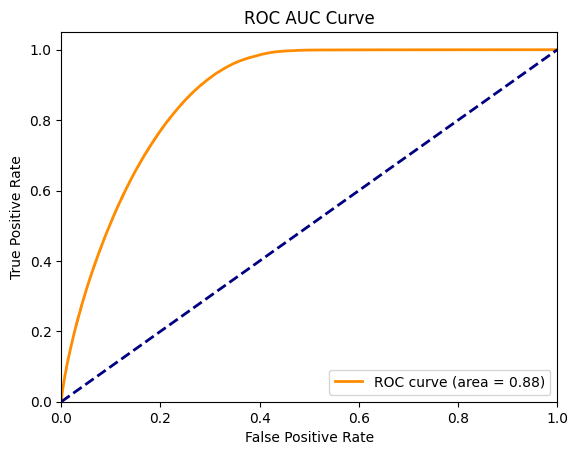

In [26]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()